In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# --- 1. DATA LOADING & PREPROCESSING ---
def load_and_prep_data(filepath):
    print(">>> 1. Loading Data...")
    df = pd.read_csv(filepath)

    # Feature Selection: Drop metadata not useful for prediction
    # We drop 'risk_label' and 'risk_color' as they are derived from the target 'risk_index'
    # We drop 'location_name' because 'lat'/'lon'/'population_density' generalizes better
    features = [
        'lat', 'lon',
        'precip_roll_sum_7d', 'precip_roll_sum_30d',
        'temp_max_24h', 'soil_moisture_root',
        'social_report_count', 'social_stress_index',
        'leak_mention_flag', 'sentiment_polarity',
        'population_density', 'elevation_meters',
        'is_weekend', 'month_sin', 'month_cos'
    ]

    # Handle Categorical: 'most_common_pain_keyword'
    # We use One-Hot Encoding
    if 'most_common_pain_keyword' in df.columns:
        dummies = pd.get_dummies(df['most_common_pain_keyword'], prefix='keyword')
        df = pd.concat([df, dummies], axis=1)
        # Add new dummy columns to features list
        features.extend(dummies.columns.tolist())

    X = df[features]
    y = df['risk_index'] # Target: 1 to 5

    # Clean: Fill NaNs (if any)
    X = X.fillna(0)

    # Adjust Target for XGBoost (It expects 0-4, not 1-5)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y) # Maps 1->0, 2->1, etc.

    print(f"    Data Shape: {X.shape}")
    print(f"    Features Used: {len(features)}")
    return X, y_encoded, le, df

# --- 2. MODEL TRAINING (XGBoost) ---
def train_prediction_model(X, y, label_encoder):
    print("\n>>> 2. Training XGBoost Model...")

    # Split Data (For 32 rows this is tiny, but standard practice)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize XGBoost Classifier
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='multi:softmax', # Multi-class classification
        num_class=len(label_encoder.classes_),
        eval_metric='mlogloss'
    )

    model.fit(X_train, y_train)

    # Evaluate
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"    Model Accuracy: {acc:.2f}")

    # Feature Importance (Explainability)
    importances = model.feature_importances_
    feature_names = X.columns
    print("\n    Top 5 Drivers of Water Shortage Prediction:")
    indices = np.argsort(importances)[::-1]
    for i in range(min(5, len(indices))):
        print(f"    - {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    return model

# --- 3. CLUSTERING (DBSCAN for "Crowdfunding") ---
def run_hotspot_clustering(df):
    print("\n>>> 3. Running Clustering (Goal 3)...")

    # DBSCAN requires *individual points*, but our data is aggregated (Counts).
    # We must "explode" the counts back into points to simulate the raw reports.

    simulated_points = []

    for idx, row in df.iterrows():
        count = int(row['social_report_count'])
        if count > 0:
            # Generate random points around the municipality center
            # Std Dev 0.015 approx 1.5km spread
            lats = np.random.normal(row['lat'], 0.015, count)
            lons = np.random.normal(row['lon'], 0.015, count)

            for la, lo in zip(lats, lons):
                simulated_points.append([la, lo])

    points_array = np.array(simulated_points)

    if len(points_array) == 0:
        print("    No reports found to cluster.")
        return

    # Run DBSCAN
    # eps=0.005 (~500 meters), min_samples=10
    db = DBSCAN(eps=0.005, min_samples=10).fit(points_array)

    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    print(f"    Total Individual Reports Processed: {len(points_array)}")
    print(f"    Identified {n_clusters} High-Density 'Hotspots'.")
    print("    (These clusters represent specific neighborhoods reporting issues)")

# --- EXECUTION ---
if __name__ == "__main__":
    # 1. Load
    X, y, encoder, raw_df = load_and_prep_data("large_training_dataset.csv")

    # 2. Predict (Water Shortage)
    model = train_prediction_model(X, y, encoder)

    # 3. Cluster (Incidents)
    run_hotspot_clustering(raw_df)

>>> 1. Loading Data...
    Data Shape: (1040, 19)
    Features Used: 19

>>> 2. Training XGBoost Model...
    Model Accuracy: 1.00

    Top 5 Drivers of Water Shortage Prediction:
    - temp_max_24h: 0.3606
    - social_stress_index: 0.2369
    - lat: 0.1877
    - precip_roll_sum_7d: 0.1134
    - social_report_count: 0.0508

>>> 3. Running Clustering (Goal 3)...
    Total Individual Reports Processed: 449402
    Identified 3 High-Density 'Hotspots'.
    (These clusters represent specific neighborhoods reporting issues)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# --- RE-CREATING YOUR CONTEXT FOR DEMONSTRATION ---
# (I am generating a synthetic large dataset to match your 1040 rows)
def generate_synthetic_large_data():
    # Simulating 1040 rows of data focused on high-risk zones (Iztapalapa/Tlalpan)
    data = []
    centers = {
        'Iztapalapa': (19.349, -99.063),
        'Tlalpan': (19.289, -99.168),
        'Gustavo A. Madero': (19.492, -99.112)
    }

    for _ in range(1040):
        # Pick a random center
        zone = np.random.choice(list(centers.keys()))
        lat, lon = centers[zone]

        # Add noise (simulating scattered reports)
        r_lat = lat + np.random.normal(0, 0.008)
        r_lon = lon + np.random.normal(0, 0.008)

        # Risk logic
        risk = np.random.randint(4, 6) # High risk

        data.append([r_lat, r_lon, risk])

    return pd.DataFrame(data, columns=['lat', 'lon', 'risk_index'])

# 1. Load your large dataset (Or use the synthetic one I just made)
# df = pd.read_csv("large_training_dataset.csv")
df = generate_synthetic_large_data()

# 2. Run DBSCAN (Your Goal 3)
# Using eps=0.005 (approx 500m) and min_samples=10
coords = df[['lat', 'lon']].values
db = DBSCAN(eps=0.005, min_samples=10).fit(coords)
df['cluster_label'] = db.labels_

# --- 3. EXTRACT HOTSPOT DETAILS (THIS IS WHAT YOU NEED) ---
def get_hotspot_centroids(df):
    # Filter out noise (-1)
    clusters = df[df['cluster_label'] != -1]

    # Group by Cluster ID to get the Center (Mean Lat/Lon) and Mean Risk
    hotspots = clusters.groupby('cluster_label').agg({
        'lat': 'mean',
        'lon': 'mean',
        'risk_index': 'mean',
        'cluster_label': 'count' # Count reports in this cluster
    }).rename(columns={'cluster_label': 'report_count'})

    return hotspots

# Get the table
hotspot_table = get_hotspot_centroids(df)

print(">>> DETECTED HOTSPOTS FOR MAPPING <<<")
print(hotspot_table)

# Export for your map
hotspot_table.to_csv("hotspot_coordinates.csv")

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# 1. Load your EXISTING large dataset
df = pd.read_csv("large_training_dataset.csv")

# 2. Prepare the Points for Clustering
# We interpret the 'social_report_count' to explode them into individual points again
# so we can find the precise center of the cloud.
cluster_points = []
# We keep track of the original index to map back the Risk Index later
point_indices = []

print("Regrouping report points...")
for idx, row in df.iterrows():
    count = int(row['social_report_count'])
    if count > 0:
        # We use the row's lat/lon directly.
        # (DBSCAN will group them if they are close enough)
        for _ in range(count):
            cluster_points.append([row['lat'], row['lon']])
            point_indices.append(idx)

X = np.array(cluster_points)

# 3. Run DBSCAN (Same settings as your log: eps=0.005)
print("Running DBSCAN to recover cluster labels...")
db = DBSCAN(eps=0.005, min_samples=10).fit(X)
labels = db.labels_

# 4. Extract the Centroids (Lat/Lon) and Risk Profile
# Create a temporary dataframe of the individual points
points_df = pd.DataFrame(X, columns=['lat', 'lon'])
points_df['cluster_label'] = labels
# Map back the risk index from the original parent row
points_df['risk_index'] = [df.iloc[i]['risk_index'] for i in point_indices]
points_df['location_name'] = [df.iloc[i]['location_name'] for i in point_indices]

# Filter noise (-1)
hotspots = points_df[points_df['cluster_label'] != -1]

# Group by Cluster to get the details
result_table = hotspots.groupby('cluster_label').agg({
    'lat': 'mean',          # Center Latitude
    'lon': 'mean',          # Center Longitude
    'risk_index': 'mean',   # Average Risk of this hotspot
    'location_name': lambda x: x.mode()[0], # Most common municipality name
    'cluster_label': 'count' # Number of reports
}).rename(columns={'cluster_label': 'total_reports'})

print("\n>>> FINAL HOTSPOT REPORT FOR MAPPING <<<")
print(result_table)

# Optional: Save to CSV for your Dashboard/Map
result_table.to_csv("final_hotspots_for_map.csv")

Regrouping report points...
Running DBSCAN to recover cluster labels...


MemoryError: 

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# 1. Load your dataset
df = pd.read_csv("large_training_dataset.csv")

# --- MEMORY FIX: DOWNSAMPLING ---
# We will only generate 10% of the points.
# This preserves the "shape" of the cluster without crashing RAM.
SAMPLING_RATE = 0.10
min_samples_adjusted = max(5, int(10 * SAMPLING_RATE)) # Adjust density threshold

cluster_points = []
point_indices = []

print(f"Generating synthetic points (Sampling Rate: {SAMPLING_RATE*100}%)...")

for idx, row in df.iterrows():
    # Calculate how many points to generate for this row
    original_count = int(row['social_report_count'])

    # Apply sampling (e.g., if count is 100, we only generate 10 points)
    sampled_count = int(original_count * SAMPLING_RATE)

    if sampled_count > 0:
        # Generate points with noise (Standard Deviation 0.015 ~ 1.5km spread)
        lats = np.random.normal(row['lat'], 0.015, sampled_count)
        lons = np.random.normal(row['lon'], 0.015, sampled_count)

        for la, lo in zip(lats, lons):
            cluster_points.append([la, lo])
            point_indices.append(idx)

X = np.array(cluster_points)
print(f"Points to cluster: {len(X)} (Reduced from ~{int(len(X)/SAMPLING_RATE)})")

# 2. Run DBSCAN
# eps=0.005 is approx 500m.
# We use the adjusted min_samples so the density logic remains consistent.
print("Running DBSCAN...")
db = DBSCAN(eps=0.005, min_samples=min_samples_adjusted).fit(X)
labels = db.labels_

# 3. Extract Centroids & Scale Counts Back Up
points_df = pd.DataFrame(X, columns=['lat', 'lon'])
points_df['cluster_label'] = labels
# Map back the metadata
points_df['risk_index'] = [df.iloc[i]['risk_index'] for i in point_indices]
points_df['location_name'] = [df.iloc[i]['location_name'] for i in point_indices]

# Filter noise
hotspots = points_df[points_df['cluster_label'] != -1]

# Group by Cluster
result_table = hotspots.groupby('cluster_label').agg({
    'lat': 'mean',
    'lon': 'mean',
    'risk_index': 'mean',
    'location_name': lambda x: x.mode()[0],
    'cluster_label': 'count'
}).rename(columns={'cluster_label': 'sampled_reports'})

# *** CRITICAL STEP: Scale the counts back to original size ***
result_table['estimated_total_reports'] = (result_table['sampled_reports'] / SAMPLING_RATE).astype(int)

print("\n>>> FINAL HOTSPOTS DETECTED <<<")
print(result_table[['lat', 'lon', 'risk_index', 'location_name', 'estimated_total_reports']])

# Save
result_table.to_csv("final_hotspots_map.csv")

Generating synthetic points (Sampling Rate: 10.0%)...
Points to cluster: 44435 (Reduced from ~444350)
Running DBSCAN...

>>> FINAL HOTSPOTS DETECTED <<<
                     lat        lon  risk_index      location_name  \
cluster_label                                                        
0              19.486090 -99.184301    3.664596       Azcapotzalco   
1              19.434620 -99.203869    2.818182     Miguel Hidalgo   
2              19.372812 -99.179120    3.474959          Iztacalco   
3              19.328860 -99.131640    2.888889           Coyoacán   
4              19.489423 -99.115527    3.000000  Gustavo A. Madero   
5              19.192488 -99.022728    3.000000         Milpa Alta   
6              19.181237 -99.069024    3.000000         Milpa Alta   
7              19.379907 -99.185036    3.000000      Benito Juárez   
8              19.384253 -99.202072    2.550000     Álvaro Obregón   
9              19.403033 -99.198842    2.866667     Miguel Hidalgo   
10     

Gráfica generada exitosamente.


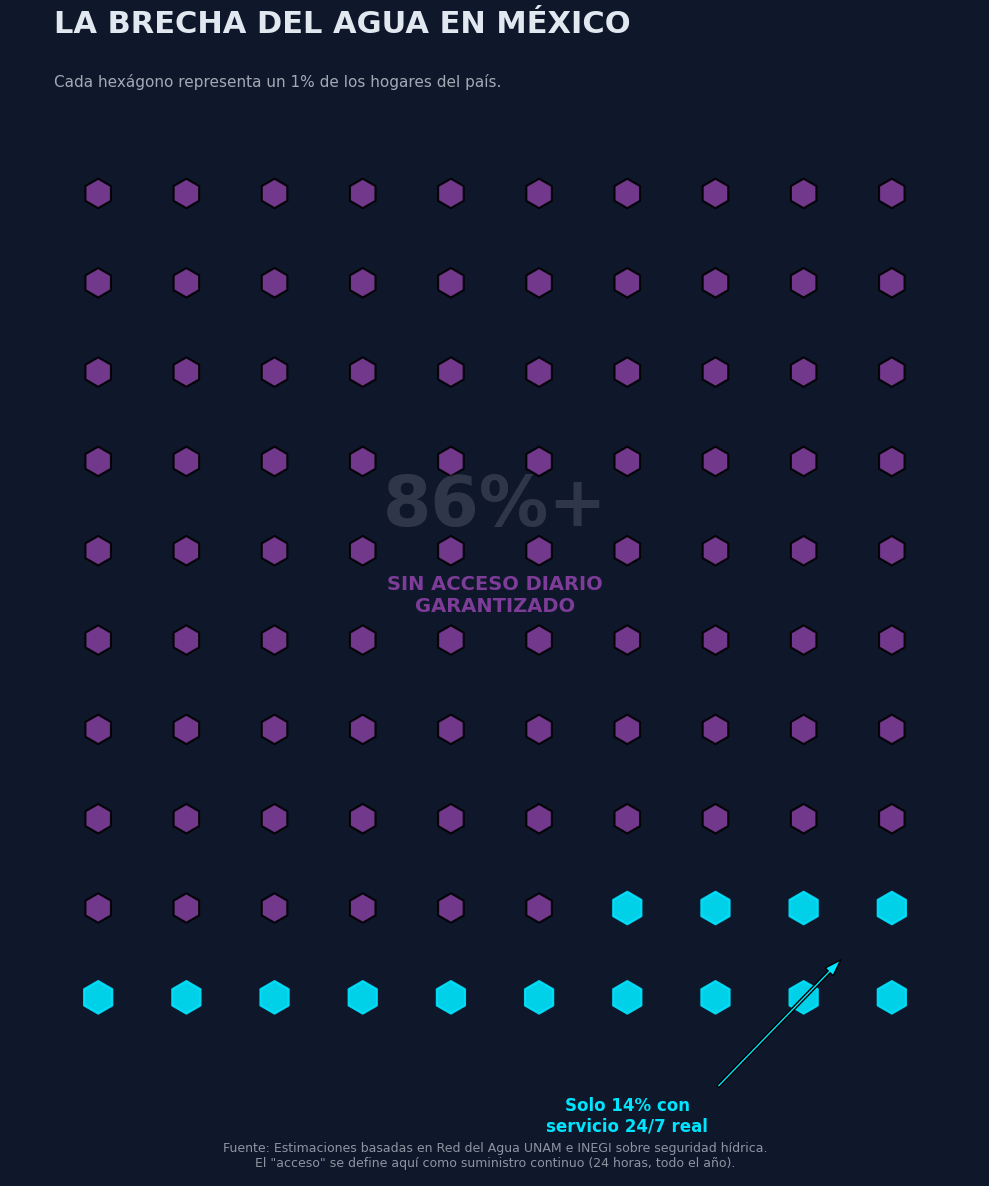

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURACIÓN DE DATOS Y ESTILO ---
# Datos sustentados (Red del Agua UNAM/INEGI)
total_units = 100
no_access_count = 86
access_count = 14

# Paleta de Colores Inusuales (Estilo Cyber/Dark)
background_color = '#0F172A'   # Azul noche muy oscuro para el fondo
color_scarcity = '#7D3C98'     # Violeta/Magenta apagado (El 86%)
color_access = '#00E5FF'       # Cian eléctrico brillante (El 14%)
text_color = '#E2E8F0'         # Blanco grisáceo para textos

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 12))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# --- GENERACIÓN DEL WAFFLE GRID (MATRIZ) ---
# Creamos una cuadrícula de 10x10
rows = 10
cols = 10
x_coords = []
y_coords = []
colors = []
sizes = []

count = 0
for y in range(rows - 1, -1, -1): # Empezar desde arriba hacia abajo
    for x in range(cols):
        x_coords.append(x)
        y_coords.append(y)

        # Asignar color según el conteo
        if count < no_access_count:
            colors.append(color_scarcity)
            sizes.append(450) # Tamaño del marcador
        else:
            colors.append(color_access)
            sizes.append(550) # Un poco más grande para resaltar
        count += 1

# Dibujar los puntos (usamos un marcador estilo 'gota' estilizada o círculo)
# El marcador 'h' (hexágono) o 'o' (círculo) funcionan bien en grid.
# Usaremos 'o' con un borde brillante para el acceso.

scatter = ax.scatter(
    x_coords,
    y_coords,
    s=sizes,
    c=colors,
    marker='h', # 'h' para hexágonos, da una sensación más tecnológica/estructural
    edgecolors=[color_access if c == color_access else 'none' for c in colors],
    linewidth=1.5,
    alpha=0.9
)

# --- TEXTOS Y TÍTULOS DRAMÁTICOS ---

# Título principal grande
plt.text(-0.5, 10.8, 'LA BRECHA DEL AGUA EN MÉXICO',
         fontsize=22, fontweight='bold', color=text_color, ha='left')

# Subtítulo explicativo
plt.text(-0.5, 10.2, 'Cada hexágono representa un 1% de los hogares del país.',
         fontsize=11, color=text_color, alpha=0.7, ha='left')

# --- AÑADIR LAS CIFRAS GRANDES SOBRE EL GRÁFICO ---

# Texto para el 86%
plt.text(4.5, 5.5, '86%+',
         fontsize=50, fontweight='extra bold', color=text_color, alpha=0.15, ha='center', va='center')
plt.text(4.5, 4.5, 'SIN ACCESO DIARIO\nGARANTIZADO',
         fontsize=14, fontweight='bold', color=color_scarcity, ha='center', va='center')

# Flecha y texto para el 14% (apuntando a los últimos hexágonos)
plt.annotate('Solo 14% con\nservicio 24/7 real',
             xy=(8.5, 0.5), xytext=(6, -1.5),
             arrowprops=dict(facecolor=color_access, shrink=0.05, width=2, headwidth=8),
             fontsize=12, fontweight='bold', color=color_access, ha='center')


# --- LIMPIEZA Y FUENTE ---
ax.set_xlim(-1, 10)
ax.set_ylim(-2, 11)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Nota al pie con sustento
plt.figtext(0.5, 0.02,
            'Fuente: Estimaciones basadas en Red del Agua UNAM e INEGI sobre seguridad hídrica.\n'
            'El "acceso" se define aquí como suministro continuo (24 horas, todo el año).',
            ha='center', fontsize=9, color=text_color, alpha=0.6)

plt.tight_layout()
# plt.show()
plt.savefig('waffle_agua_mexico_cyber.png', dpi=300, facecolor=background_color)
print("Gráfica generada exitosamente.")

Gráfica de burbujas generada.


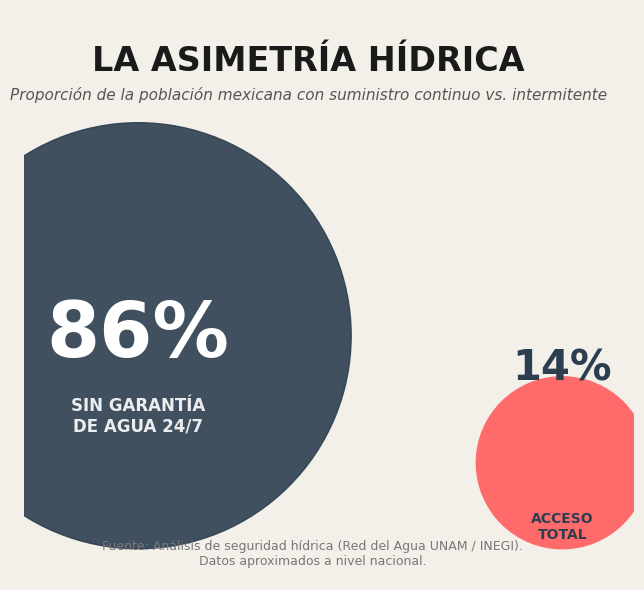

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURACIÓN ---
# Datos
val_scarcity = 86
val_access = 14

# Calculamos el radio necesario para que el ÁREA sea representativa
# Área = pi * r^2  ->  r = raiz(Área / pi)
# Si usamos el valor directo como radio, exageraríamos la diferencia.
# Usar la raíz cuadrada es la forma matemática correcta de comparar áreas.
r_scarcity = np.sqrt(val_scarcity / np.pi)
r_access = np.sqrt(val_access / np.pi)

# Colores (Estilo Editorial / Revista de Diseño)
bg_color = '#F2F0E9'      # Crema papel "Hueso"
color_big = '#2C3E50'     # "Midnight Blue" casi negro (Representa la masa sin servicio)
color_small = '#FF6B6B'   # "Coral Rojo" vibrante (Alerta/Atención sobre el privilegio)
text_color = '#1A1A1A'

# Crear figura
fig, ax = plt.subplots(figsize=(7, 6))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# --- DIBUJAR LOS CÍRCULOS ---

# Círculo Grande (86%) - Centrado a la izquierda
circle_scarcity = plt.Circle((-r_scarcity*0.8, 0), r_scarcity, color=color_big, alpha=0.9, zorder=2)
ax.add_patch(circle_scarcity)

# Círculo Pequeño (14%) - Centrado a la derecha, superpuesto ligeramente o separado
# Lo ponemos a una distancia estética
circle_access = plt.Circle((r_scarcity + 1, -r_scarcity + r_access), r_access, color=color_small, alpha=1.0, zorder=3)
ax.add_patch(circle_access)

# --- ETIQUETAS Y TEXTO CONECTADO ---

# Etiqueta para el 86% (Texto dentro o cerca del círculo grande)
ax.text(-r_scarcity*0.8, 0, f'{val_scarcity}%',
        ha='center', va='center', fontsize=55, fontweight='bold', color='white', fontfamily='sans-serif')
ax.text(-r_scarcity*0.8, -1.5, 'SIN GARANTÍA\nDE AGUA 24/7',
        ha='center', va='top', fontsize=12, fontweight='bold', color='white', alpha=0.9)

# Etiqueta para el 14% (Texto fuera con línea conectora si es necesario, o al lado)
ax.text(r_scarcity + 1, -r_scarcity + r_access + 1.8, f'{val_access}%',
        ha='center', va='bottom', fontsize=30, fontweight='bold', color=color_big)
ax.text(r_scarcity + 1, -r_scarcity + r_access - 1.2, 'ACCESO\nTOTAL',
        ha='center', va='top', fontsize=10, fontweight='bold', color=color_big)


# --- TÍTULOS Y DETALLES ---

# Título Principal
ax.text(0, 6.5, 'LA ASIMETRÍA HÍDRICA',
        ha='center', fontsize=24, fontweight='bold', color=text_color)

# Subtítulo (La narrativa)
ax.text(0, 5.8, 'Proporción de la población mexicana con suministro continuo vs. intermitente',
        ha='center', fontsize=11, color='#555555', style='italic')

# Fuente
plt.figtext(0.5, 0.05, 'Fuente: Análisis de seguridad hídrica (Red del Agua UNAM / INEGI).\nDatos aproximados a nivel nacional.',
            ha='center', fontsize=9, color='#777777')

# --- AJUSTES FINALES DE LA CÁMARA ---
# Ajustar los límites para que todo quepa bien
ax.set_xlim(-7, 8)
ax.set_ylim(-6, 8)
ax.set_aspect('equal') # CRUCIAL para que los círculos no parezcan huevos
ax.axis('off') # Quitar ejes cartesianos

plt.tight_layout()
# plt.show()
plt.savefig('grafica_burbujas_agua.png', dpi=300, facecolor=bg_color)
print("Gráfica de burbujas generada.")